In [19]:
import sage #pip install sage-importance
import shap

from itertools import combinations
import numpy as np
import pandas as pd
import xgboost
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## Data and model

In [2]:
df = sage.datasets.bike()
features = df.columns.tolist()[:-3]
target = df.columns.tolist()[-1]

In [3]:
print("Features:", features)
print("Target:", target)

Features: ['Year', 'Month', 'Day', 'Hour', 'Season', 'Holiday', 'Workingday', 'Weather', 'Temp', 'Atemp', 'Humidity', 'Windspeed']
Target: Count


In [4]:
# Split data, with total count serving as regression target
train, test = train_test_split(df, test_size=int(0.1 * len(df.values)), random_state=123)
train, bkg = train_test_split(train, test_size=int(0.1 * len(df.values)), random_state=123)

y_train = train[[target]]
y_bkg = bkg[[target]]
y_test = test[[target]]
x_train = train[features]
x_bkg = bkg[features]
x_test = test[features]

In [5]:
model = xgboost.XGBRegressor()
model.fit(x_train, y_train);

In [6]:
# Calculate performance
mean = np.mean(y_train)
base_mse = np.mean((mean - y_test) ** 2)
mse = np.mean((model.predict(x_test) - y_test.to_numpy().flatten())**2)

print("Base rate MSE = {:.2f}".format(base_mse))
print("Model MSE = {:.2f}".format(mse))

Base rate MSE = 31591.23
Model MSE = 1878.77


## SAGE values and plot

In [7]:
X = x_bkg.to_numpy()          # (N, d)
Y = np.asarray(y_bkg).ravel() # (N,)

imputer = sage.MarginalImputer(model, X[:512])
estimator = sage.PermutationEstimator(imputer, "mse")
sage_values = estimator(X, Y)

  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
print("Number of features:", len(features))
print("Number of SAGE values:", len(sage_values.values))
print(sage_values)

Number of features: 12
Number of SAGE values: 12
SAGE Explanation(
  (Mean): [ 2740.89  1387.21    58.79 18343.24     0.00    23.11  2758.47   210.73
  1682.53   757.53  1248.35   -37.52]
  (Std):  [139.79  88.76  23.74 456.73   0.00  10.81 142.29  51.11  83.11  42.86
  63.82  19.81]
)


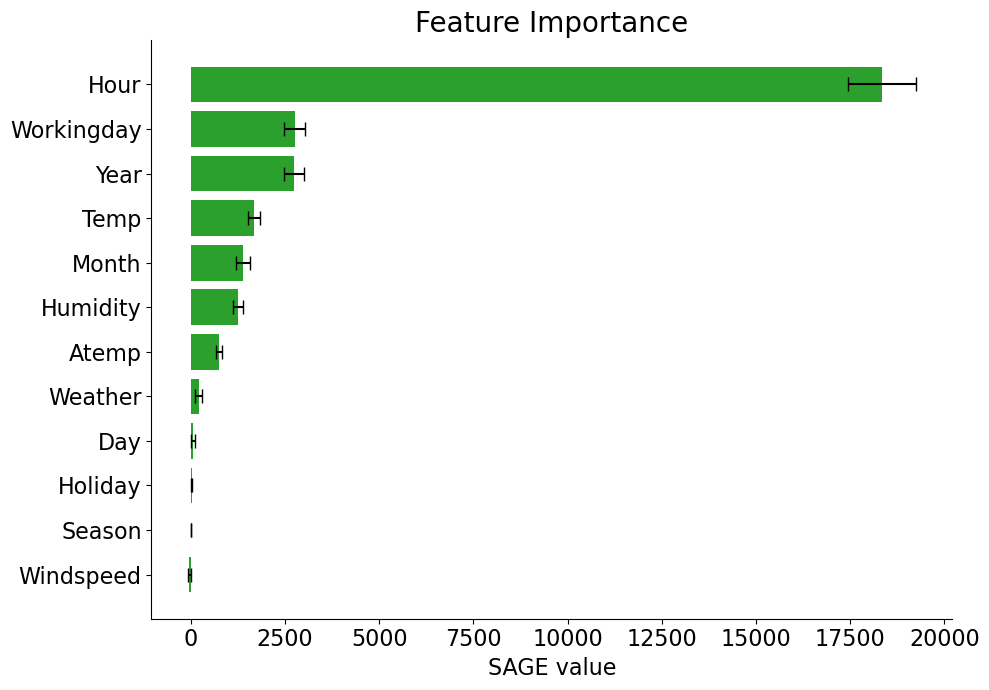

In [9]:
# Plot results
sage_values.plot(features)

### Imputers and loss functions

In [10]:
imputer = sage.MarginalImputer(model, X[:512])
imputer

In [11]:
estimator = sage.PermutationEstimator(imputer, "mse")
estimator.loss_fn

In [12]:
sage_values = estimator(X, Y)

  0%|          | 0/1 [00:00<?, ?it/s]

## Comparison to SHAP

In [64]:
explainer = shap.TreeExplainer(model, data=x_bkg)
shap_values = explainer.shap_values(x_test)

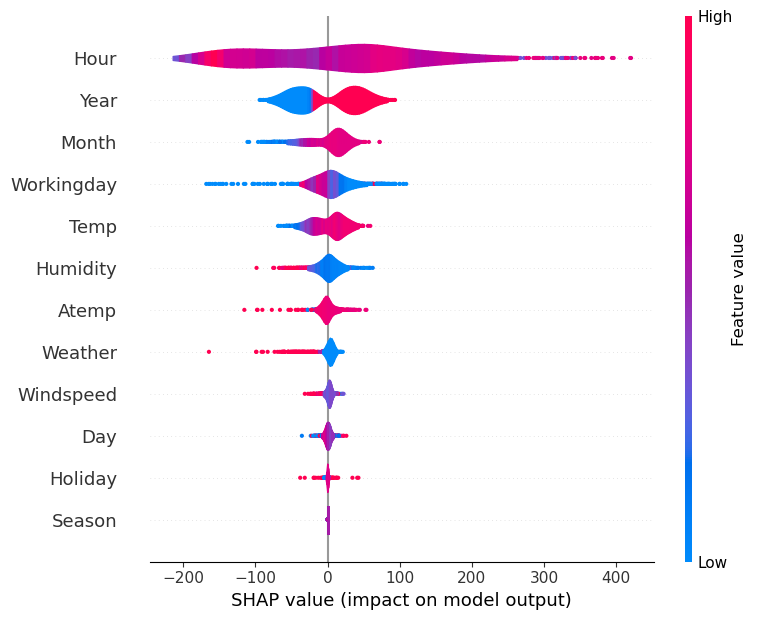

In [65]:
shap.summary_plot(shap_values, x_test, plot_type="violin")

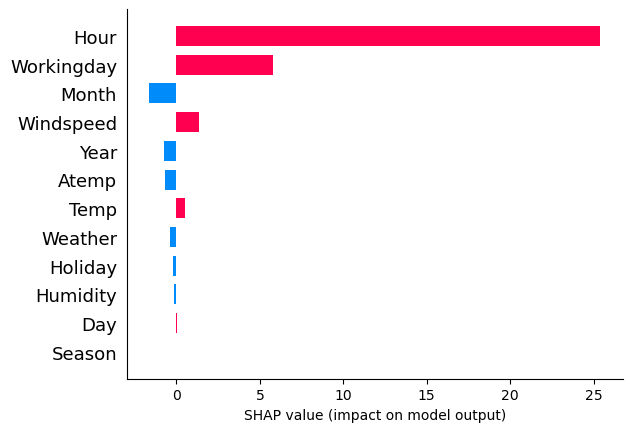

In [15]:
shap_mean = np.mean(shap_values, axis=0)
shap.bar_plot(shap_mean, feature_names=features, max_display=12)

In [16]:
df["Year"]

0        2011
1        2011
2        2011
3        2011
4        2011
         ... 
10881    2012
10882    2012
10883    2012
10884    2012
10885    2012
Name: Year, Length: 10886, dtype: int32

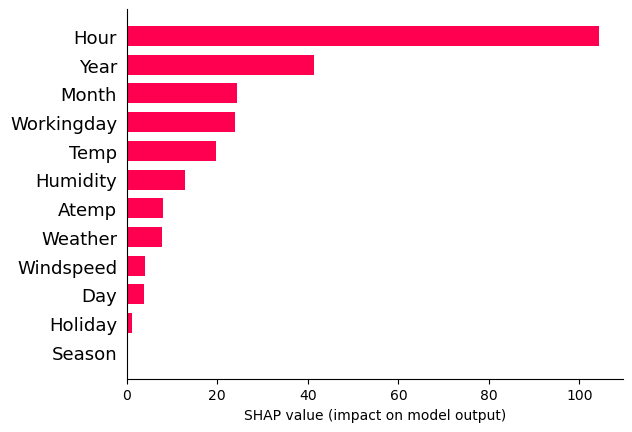

In [17]:
shap_mean = np.mean(np.abs(shap_values), axis=0)
shap.bar_plot(shap_mean, feature_names=features, max_display=12)

## Comparison to LOFO

In [23]:
full_mse = mse(model.predict(x_test), y_test.to_numpy().flatten())

def lofo(model, features, train_df, y_train, test_df, y_test, loss):
    losses = {}
    lofos_ratio = {}
    lofos_diff = {}

    for _features in combinations(features, len(features)-1):
        _excluded = list(set(features) - set(_features))[0]
        _features = list(_features)
        _x_train = train_df[_features]
        _x_test = test_df[_features]
    
        _model = xgboost.XGBRegressor()
        _model.fit(_x_train, y_train);

        _loss = loss(_model.predict(_x_test), y_test.to_numpy().flatten())

        losses[_excluded] = _loss

    for _feature in features:
        lofos_ratio[_feature] = losses[_feature]/full_mse
        lofos_diff[_feature] = losses[_feature]-full_mse

    return lofos_ratio, lofos_diff

def mse(prediction, target):
    return np.mean((prediction - target)**2).item()

In [24]:
lofos_ratio, lofos_diff = lofo(model, features, train, y_train, test, y_test, mse)

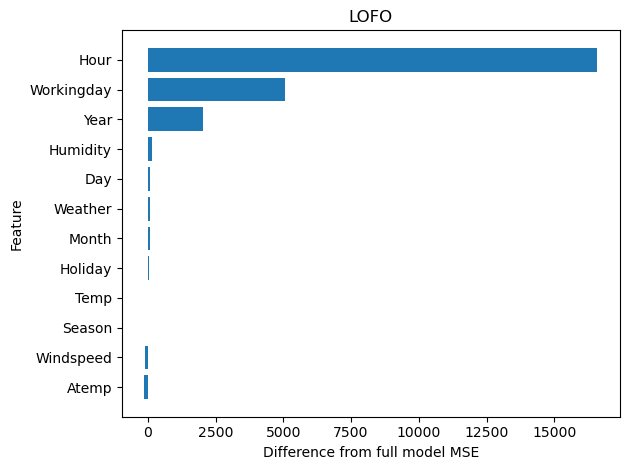

In [34]:
# Create horizontal bar plot from sorted values
sorted_items = sorted(lofos_diff.items(), key=lambda x: x[1])
keys, values = zip(*sorted_items)

plt.barh(range(len(keys)), values)
plt.yticks(range(len(keys)), keys)
plt.xlabel('Difference from full model MSE')
plt.ylabel('Feature')
plt.title('LOFO')
plt.tight_layout()
plt.show()

## Comparison to SHAP and LOFO

In [48]:
SHAP = shap_mean
SAGE = sage_values.values
LOFOS = [lofos_diff[_feature] for _feature in features]

In [49]:
def normalize(x):
    x = np.array(x)
    return x / x.sum()

sage_norm = normalize(SAGE)
shap_norm = normalize(SHAP)
lofo_norm = normalize(LOFOS)

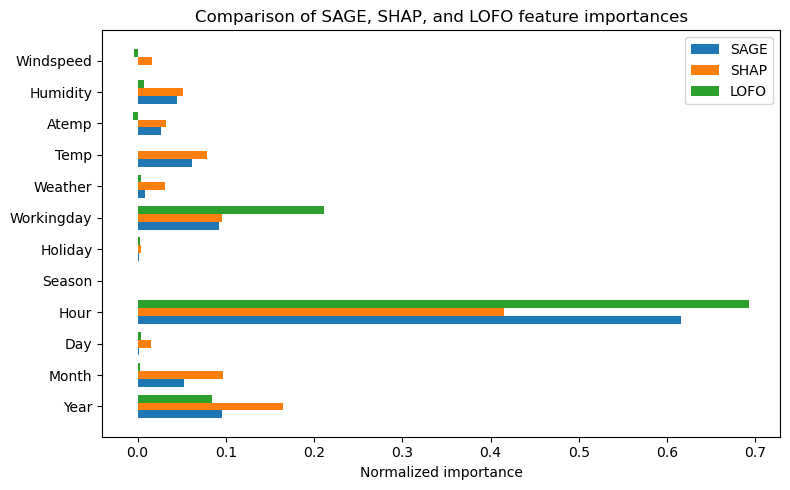

In [55]:
# Plot grouped bars
x = np.arange(len(features))
width = 0.25

plt.figure(figsize=(8,5))
plt.barh(x - width, sage_norm, width, label='SAGE')
plt.barh(x, shap_norm, width, label='SHAP')
plt.barh(x + width, lofo_norm, width, label='LOFO')

plt.yticks(x, df['Feature'])
plt.xlabel('Normalized importance')
plt.title('Comparison of SAGE, SHAP, and LOFO feature importances')
plt.legend()
plt.tight_layout()
plt.show()

## Homework part 2: Study correlation structure in the data and investigate a datapoint with SHAP

In [35]:
feature_list = list(keys)
feature_list.reverse()

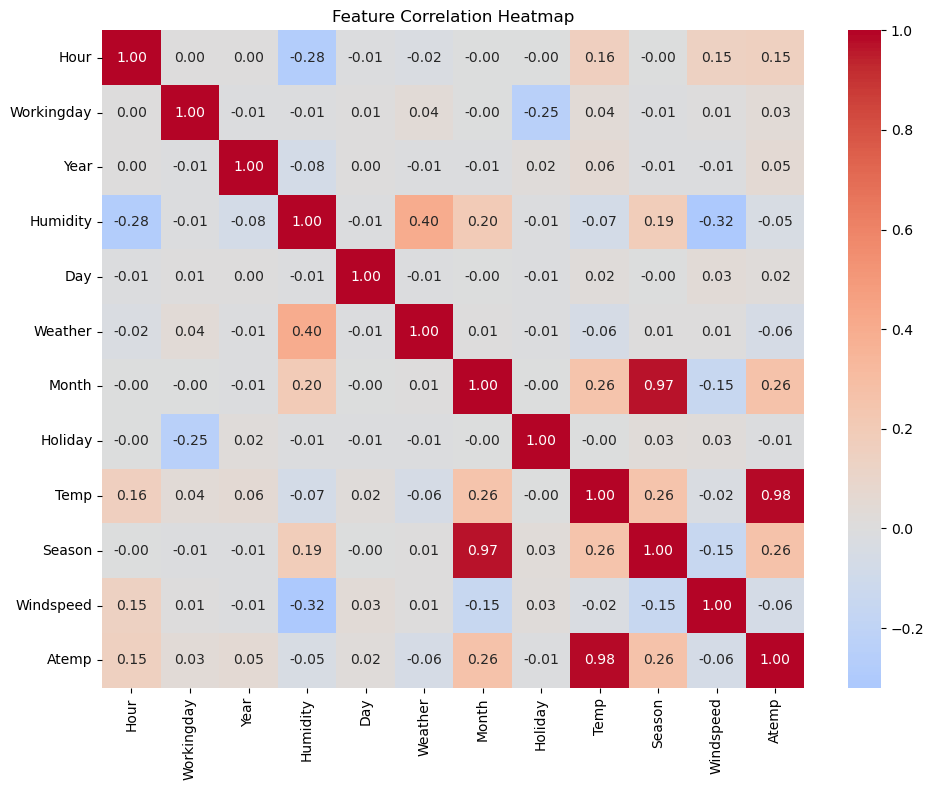

In [36]:
# Compute correlation matrix
corr = train[feature_list].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt=".2f")

plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

We see that the feature "Month" correlates strongly with Season and Temperature. 

Let's find a point for which the SHAP value of Month is high, and look at the SHAP explaination

In [62]:
interesting = "Month"
f_idx = features.index(interesting)

# shap_values shape: (n_samples, n_features)
abs_shap = np.abs(shap_values[:, f_idx])

# Get top indices and values
top_idx = np.argsort(abs_shap)[::-1][:10]
print("Top samples with high SHAP for", interesting, ":", top_idx)
print("SHAP values:", shap_values[top_idx, f_idx])

Top samples with high SHAP for Month : [ 438  350  450  632  739  691 1031  102  889  917]
SHAP values: [-111.01751961 -108.73147482  -96.36441475  -92.28717958  -92.14128562
  -90.68881544  -90.32328162  -88.71882324  -88.29298175  -87.7180561 ]


In [78]:
shap.initjs()
index = top_idx[0].item()
shap.force_plot(explainer.expected_value, shap_values[index,:], x_test.iloc[index,:])

12